# Main Tic-Tac-Toe Game

In [1]:
import time
import datetime
import random
from enum import Enum

import numpy as np
from tabulate import tabulate as tb

# GLOBAL VARIABLES
user, ticAI, empty, timer = "X", "O", "_", 3


class TicTacToeState(Enum):
    draw, progress, x, o = "Draw", "In Progress", "X", "O"


# FEW CLASSES TO HANDLE EXCEPTION ERRORS/RULE VIOLATIONS
# when user move is not a digit
class NotDigit(Exception):
    pass


# when user move is a digit higher than allowable cell positions
class BeyondCellBoundaries(Exception):
    pass


# when user enters a move in an already filled cell
class FilledCell(Exception):
    pass

# Class to Manage Entire TicTacToe Board
class TicBoard:
    def __init__(self, size):
        self.size = size
        self.board = [["_" for _ in range(size)] for _ in range(size)]
        self.finalMove = None

    def getFinalMove(self):
        return self.finalMove

  # Display TicTacToe
    def displayBoard(self):
        print("Board Filled With Numbers is Reference Board")
        referenceboard = np.arange(self.size**2).reshape(self.size, -1)
        for x in range(self.size):
            for y in range(self.size):
                if y < self.size - 1:
                    print(referenceboard[x][y], end="|")
                else:
                    print(referenceboard[x][y], end="")
            print()

        print(tb(self.board, tablefmt="fancy_grid"))

    # Gets rows and columns
    def getEntireRow(self, nr):
        return self.board[nr]

    def getEntireCol(self, nc):
        return [r[nc] for r in self.board]

  #Using 0-indexing this gets the cell user selects and converts it to board cell.
    def getCell(self, cell):
        r, c = cell // self.size, cell % self.size
        return r, c

    # Method to get the board diagonals
    def getEntireDiagonals(self):
        y, d1, d2 = 0, [self.board[x][x] for x in range(self.size)], []
        for x in list(range(self.size)[::-1]):  # check here
            d2.append(self.board[x][y])
            y += 1
        return d1, d2

    def getPrimaryDiag(self):
        return [self.board[x][x] for x in range(self.size)]

    # Method to check if a given cell is on the primary diagonal
    def isOnPrimaryDiag(self, cell):
        return cell % (self.size + 1) == 0

    def getAltDiag(self):
        y, d2 = 0, []
        for x in list(range(self.size)[::-1]):  # check here
            d2.append(self.board[x][y])
            y += 1
        return d2

    def isOnAltDiag(self, cell):
        return cell % (self.size - 1) == 0

    # Methods to get cell position and tick "_"/"o"/x" on board
    def tickNothing(self, cell):
        r, c = self.getCell(cell)
        self.board[r][c] = "_"

    def tickUser(self, cell):
        self.finalMove = cell
        r, c = self.getCell(cell)
        self.board[r][c] = "X"

    def tickAI(self, cell):
        self.finalMove = cell
        r, c = self.getCell(cell)
        self.board[r][c] = "O"

    # Method to check if a line in board is filled with same "x"/"o"
    def isLineFilledSame(self, check, m):
        return all(i == m for i in check)

    def isCellEmpty(self, cell):
        r, c = self.getCell(cell)
        return self.board[r][c] == "_"


#Class that controls the entire Game and its activities
class TicTacToe:
    """
    gameSize - gets board size
    dtimer - time alloted for AI to do a search and make a move by then
    users - number of users playing the game
    simulate - boolean whether we want to simulate a player who will play vs AI rather than us playing
    dispay - whether we want to display board everytime
    """
    def __init__(self, gameSize, dtimer, users, simulate, display):
        self.display = display
        self.numusers = users
        self.tGame = TicBoard(gameSize)
        self.gameSize = gameSize
        self.usernames = [' '] * users
        self.turn = None
        self.whoStartsGame()
        self.bestM = 0
        self.AIFirstMove = None
        self.dtimer = dtimer
        self.simulate = simulate
        

    def getUsername(self):
        accumulator = 1
        while accumulator <= self.numusers:
            try:
                if self.simulate == False:
                    userN = input("Welcome to TicTacToe Game, Please Enter Player " + str(accumulator) + " Name: ")
                elif self.simulate == True:
                    userN = "RandomPlayer"
                if userN is None:
                    raise ValueError("Kindly enter your name")
                self.usernames[accumulator - 1] = userN
                accumulator += 1
            except ValueError as i:
                print(i)

    # Method to get next tick/move from player
    def getUserTick(self):
        while True:
            try:
                if self.simulate == False:
                    userM = int(input(self.usernames[self.turn] + " kindly pick a cell to make your move: "))
                elif self.simulate == True:
                    if self.display:
                        print("Random Player is making move...")
                    userM = int(np.random.choice(self.computeValidMoves()))
                if not isinstance(userM, int):
                    raise NotDigit("Integer Digits Only")
                if not self.tGame.isCellEmpty(userM):
                    raise FilledCell("Cell already ticked, please tick another")
                if not (0 <= userM <= (self.gameSize ** 2 - 1)):
                    raise BeyondCellBoundaries("You are ticking outside cell boundaries, please tick again")
                return userM
            except(NotDigit, FilledCell, BeyondCellBoundaries) as i:
                print(i)
            except Exception:
                print("Invalid Move")

    # Method to emulate a cointoss to decide who starts game
    def whoStartsGame(self):
        whostarts = np.random.choice(["user", "AI"])
        if whostarts == "user":
            self.turn = 0
            if self.display == True:
                print("After a coinflip, User will be making First Move")
        else:
            self.AIFirstMove, self.turn = random.randrange(self.tGame.size ** 2), 1
            if self.display == True:
                print("After a coinflip, AI will be making First Move")

    # Next two methods checks if a player has tied or won
    def checkDraw(self):
        for cell in range(self.tGame.size ** 2):
            if self.tGame.isCellEmpty(cell): return False
        return True

    def checkWin(self, move):
        m = ""
        if move % 2 == 0:
            m = user
        else:
            m = ticAI
        finalM = self.tGame.getFinalMove()
        r, c = self.tGame.getCell(finalM)
        if self.tGame.isLineFilledSame(self.tGame.getEntireRow(r), m) or self.tGame.isLineFilledSame(
            self.tGame.getEntireCol(c), m):
            return True
        if self.tGame.isOnPrimaryDiag(finalM) and self.tGame.isLineFilledSame(self.tGame.getPrimaryDiag(), m):
            return True
        if self.tGame.isOnAltDiag(finalM) and self.tGame.isLineFilledSame(self.tGame.getAltDiag(), m):
            return True
        return False

    def checkTicTacToeState(self):
        if self.checkDraw(): return "Draw"
        if self.checkWin(0): return "X"
        if self.checkWin(1): return "O"
        return "In Progress"

    # Method to check all valid moves left one can make in the game
    def computeValidMoves(self):
        valid = []
        for cell in range(self.tGame.size ** 2):
            if self.tGame.isCellEmpty(cell): valid.append(cell)
        return valid

    # THIS METHOD TAKES CARE OF THE GAME
    def BeginGame(self):
        outcome = 0 # measures AI outcome
        self.getUsername()
        while True:
            if self.display:
                self.tGame.displayBoard()
            self.turn %= 2
            if self.turn % 2 == 0:
                userM = self.getUserTick()
                self.tGame.tickUser(userM)
            else:
                if self.display:
                    print("AI is ticking a cell........ in ", str(self.dtimer), " seconds")
                if self.AIFirstMove is not None:
                    aiM = self.AIFirstMove
                    self.AIFirstMove = None
                else:
                    aiM = self.iterativeDeepening()
                self.tGame.tickAI(aiM)
            currentResult = self.checkTicTacToeState()
            if currentResult != "In Progress":
                if self.display:
                    self.tGame.displayBoard()
                if currentResult == "Draw":
                    if self.display == True:
                        print("GAME ENDED: DRAW!!!")
                    outcome = 0
                else:
                    if self.turn % 2 == 0:
                        if self.display == True:
                            print("GAME ENDED: ", self.usernames[self.turn], "WON!!!")
                        outcome = -1
                    else:
                        if self.display == True:
                            print("GAME ENDED: AI WON, YOU LOST!!!")
                        outcome = 1
                return outcome
                break
            self.turn += 1

    # THIS IS THE PART WHERE WE UTILIZE AI SEARCH STRATEGIES SUCH AS MINIMAX AND ITERATIVE DEEPENING

    # On a given line, this will check the number of x/o/empty cells it has
    def checkLine(self, line):
        return line.count("O"), line.count("X"), line.count("_")

    # On a given line, this will calculate the score of that line.
    def getLinePoints(self, line):
        aiPoints, userPoints, emptyPoints = self.checkLine(line)
        points = 0
        if aiPoints == 0 and userPoints != 0:
            points += -(10 ** (userPoints - 1))
        if userPoints == 0 and aiPoints != 0:
            if aiPoints == self.tGame.size:
                points += 11 ** (aiPoints - 1)
            points += 10 ** (aiPoints - 1)
        return points

    # Method which returns board points after evaluation of every possible line.
    def evaluateBoard(self):
        points, d = 0, self.tGame.getEntireDiagonals()
        for cell in range(self.tGame.size):
            points += self.getLinePoints(self.tGame.getEntireRow(cell))
            points += self.getLinePoints(self.tGame.getEntireCol(cell))
        for cell in range(2):
            points += self.getLinePoints(d[cell])
        return points

    def minimax(self, height, Max, alpha, beta, start, maxtime):
        """
        height - height of search tree
        Max - boolean to check whether we are maximizing or minimizing player
        alpha - keeps max's best value
        beta - keeps min's best value
        start - time AI starts search to keep track
        maxtime - max time AI has to get best move
        """
        allmoves, points, cell = self.computeValidMoves(), self.evaluateBoard(), None
        if datetime.datetime.now() - start >= maxtime:
            self.timeOver = True
        if not allmoves or height == 0 or self.timeOver:
            currentResult = self.checkTicTacToeState()
            if currentResult == "X":
                return -10 ** (self.tGame.size + 1), cell
            elif currentResult == "O":
                return 10 ** (self.tGame.size + 1), cell
            elif currentResult == "Draw":
                return 0, cell
            return points, cell

        if Max==True:
            for x in allmoves:
                self.tGame.tickAI(x)
                points, temp = self.minimax(height - 1, not Max, alpha, beta, start, maxtime)
                if points > alpha:
                    alpha = points
                    cell, self.bestM = x, x
                self.tGame.tickNothing(x)
                if beta <= alpha: break
            return alpha, cell

        else:
            for x in allmoves:
                self.tGame.tickUser(x)
                points, temp = self.minimax(height - 1, not Max, alpha, beta, start, maxtime)
                if points < beta:
                    beta = points
                    cell, self.bestM = x, x
                self.tGame.tickNothing(x)
                if alpha >= beta: break
            return beta, cell

    # Method to traverse deep into the search tree as possible to find best move within x-time given
    def iterativeDeepening(self):
        height, cell, self.timeOver = 1, None, False
        beginT = datetime.datetime.now()
        endT = beginT + datetime.timedelta(0, self.dtimer)
        while True:
            runtime = datetime.datetime.now()
            if runtime >= endT:
                break
            maxi, cell = self.minimax(height, False, -10000000, 10000000, runtime, endT - runtime)
            height += 1
        if cell == None:
            cell = self.bestM
        return cell


In [2]:
# Sample Game first parameter is size of board which is set to 4.
# Next is AI timer. Next is number of users. Next is if we want to simulate rather than actually play.
# Final parameter is if we want to display contents of board after every move. Since this was designed for N*N with N>3,
# Feel free to change N and timer in other cells
game = TicTacToe(4, 1, 1, True, True)
game.BeginGame()

After a coinflip, AI will be making First Move
Board Filled With Numbers is Reference Board
0|1|2|3
4|5|6|7
8|9|10|11
12|13|14|15
╒═══╤═══╤═══╤═══╕
│ _ │ _ │ _ │ _ │
├───┼───┼───┼───┤
│ _ │ _ │ _ │ _ │
├───┼───┼───┼───┤
│ _ │ _ │ _ │ _ │
├───┼───┼───┼───┤
│ _ │ _ │ _ │ _ │
╘═══╧═══╧═══╧═══╛
AI is ticking a cell........ in  1  seconds
Board Filled With Numbers is Reference Board
0|1|2|3
4|5|6|7
8|9|10|11
12|13|14|15
╒═══╤═══╤═══╤═══╕
│ _ │ _ │ _ │ O │
├───┼───┼───┼───┤
│ _ │ _ │ _ │ _ │
├───┼───┼───┼───┤
│ _ │ _ │ _ │ _ │
├───┼───┼───┼───┤
│ _ │ _ │ _ │ _ │
╘═══╧═══╧═══╧═══╛
Random Player is making move...
Board Filled With Numbers is Reference Board
0|1|2|3
4|5|6|7
8|9|10|11
12|13|14|15
╒═══╤═══╤═══╤═══╕
│ _ │ X │ _ │ O │
├───┼───┼───┼───┤
│ _ │ _ │ _ │ _ │
├───┼───┼───┼───┤
│ _ │ _ │ _ │ _ │
├───┼───┼───┼───┤
│ _ │ _ │ _ │ _ │
╘═══╧═══╧═══╧═══╛
AI is ticking a cell........ in  1  seconds
Board Filled With Numbers is Reference Board
0|1|2|3
4|5|6|7
8|9|10|11
12|13|14|15
╒═══╤═══╤═══╤══

1

# Testing And Simulations
**Now we will run a couple of tests to judge how good our AI is by playing random humans. We assume human will play randomly and will not use minimax strategy as AI because if not literally all will end up in ties.**

**We will run about 500 simulations for 4 by 4 and 5 by 5  and both when AI is say given 0.5 seconds and 3 seconds to make a choice. Feel free to add more NxNs and number of seconds as these simulations could take a while.**

Code for simulations is adapted from Favour Okeke's code for running simulations

4x4 in 0.5 seconds
Failure rate: 0.40%
Success rate: 66.00%

Draw rate: 33.60%



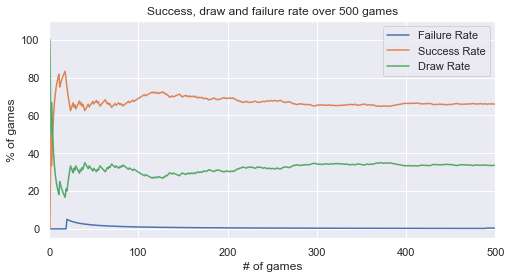

Took 1592.929 seconds


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
start = time.time()

num_sims = 500
ai_losses = 0
ai_draws = 0
ai_wins = 0
ai_loss_rate = []
ai_win_rate = []
ai_draw_rate = []

for i in range(num_sims):
    s1 = time.time()
    game1 = TicTacToe(4,0.5,1,True,False)
    outcome = game1.BeginGame()
    if outcome == -1:
        ai_losses += 1
    elif outcome == 1:
        ai_wins += 1
    elif outcome == 0:
        ai_draws += 1
    ai_loss_rate.append((ai_losses*100)/(i+1))
    ai_win_rate.append((ai_wins*100)/(i+1))
    ai_draw_rate.append((ai_draws*100)/(i+1))
    
print(f"4x4 in 0.5 seconds\nFailure rate: {(ai_losses/num_sims)*100:.2f}%")
print(f"Success rate: {(ai_wins/num_sims)*100:.2f}%\n")
print(f"Draw rate: {(ai_draws/num_sims)*100:.2f}%\n")

plt.figure(figsize = [8,4])
plt.plot(range(1, num_sims+1), ai_loss_rate, label = "Failure Rate")
plt.plot(range(1, num_sims+1), ai_win_rate, label = "Success Rate")
plt.plot(range(1, num_sims+1), ai_draw_rate, label = "Draw Rate")
plt.title(f"Success, draw and failure rate over {num_sims} games")
plt.xlabel("# of games")
plt.ylabel("% of games")
plt.axis([0,num_sims,-5,110])
plt.legend()
plt.show()

print(f"Took {time.time()-start:.3f} seconds")

4x4 in 3 seconds
Failure rate: 0.80%
Success rate: 64.80%

Draw rate: 34.40%



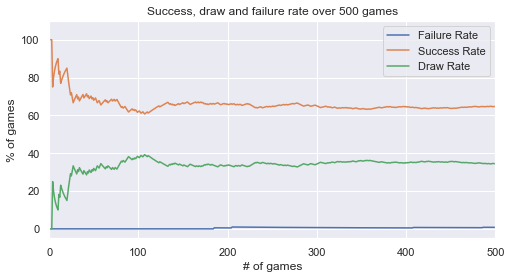

Took 9692.699 seconds


In [4]:
start = time.time()

num_sims = 500
ai_losses = 0
ai_draws = 0
ai_wins = 0
ai_loss_rate = []
ai_win_rate = []
ai_draw_rate = []

for i in range(num_sims):
    s1 = time.time()
    game1 = TicTacToe(4,3,1,True,False)
    outcome = game1.BeginGame()
    if outcome == -1:
        ai_losses += 1
    elif outcome == 1:
        ai_wins += 1
    elif outcome == 0:
        ai_draws += 1
    ai_loss_rate.append((ai_losses*100)/(i+1))
    ai_win_rate.append((ai_wins*100)/(i+1))
    ai_draw_rate.append((ai_draws*100)/(i+1))
    
print(f"4x4 in 3 seconds\nFailure rate: {(ai_losses/num_sims)*100:.2f}%")
print(f"Success rate: {(ai_wins/num_sims)*100:.2f}%\n")
print(f"Draw rate: {(ai_draws/num_sims)*100:.2f}%\n")

plt.figure(figsize = [8,4])
plt.plot(range(1, num_sims+1), ai_loss_rate, label = "Failure Rate")
plt.plot(range(1, num_sims+1), ai_win_rate, label = "Success Rate")
plt.plot(range(1, num_sims+1), ai_draw_rate, label = "Draw Rate")
plt.title(f"Success, draw and failure rate over {num_sims} games")
plt.xlabel("# of games")
plt.ylabel("% of games")
plt.axis([0,num_sims,-5,110])
plt.legend()
plt.show()

print(f"Took {time.time()-start:.3f} seconds")

10x10 in 0.5 seconds
Failure rate: 0.00%
Success rate: 98.80%

Draw rate: 1.20%



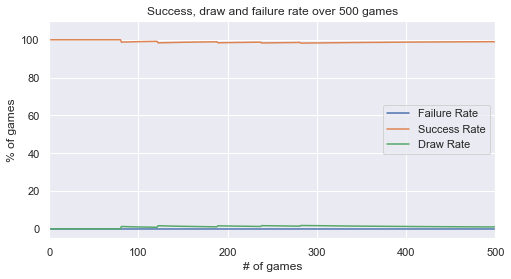

Took 3616.397 seconds


In [5]:
start = time.time()

num_sims = 500
ai_losses = 0
ai_draws = 0
ai_wins = 0
ai_loss_rate = []
ai_win_rate = []
ai_draw_rate = []

for i in range(num_sims):
    s1 = time.time()
    game1 = TicTacToe(10,0.5,1,True,False)
    outcome = game1.BeginGame()
    if outcome == -1:
        ai_losses += 1
    elif outcome == 1:
        ai_wins += 1
    elif outcome == 0:
        ai_draws += 1
    ai_loss_rate.append((ai_losses*100)/(i+1))
    ai_win_rate.append((ai_wins*100)/(i+1))
    ai_draw_rate.append((ai_draws*100)/(i+1))
    
print(f"10x10 in 0.5 seconds\nFailure rate: {(ai_losses/num_sims)*100:.2f}%")
print(f"Success rate: {(ai_wins/num_sims)*100:.2f}%\n")
print(f"Draw rate: {(ai_draws/num_sims)*100:.2f}%\n")

plt.figure(figsize = [8,4])
plt.plot(range(1, num_sims+1), ai_loss_rate, label = "Failure Rate")
plt.plot(range(1, num_sims+1), ai_win_rate, label = "Success Rate")
plt.plot(range(1, num_sims+1), ai_draw_rate, label = "Draw Rate")
plt.title(f"Success, draw and failure rate over {num_sims} games")
plt.xlabel("# of games")
plt.ylabel("% of games")
plt.axis([0,num_sims,-5,110])
plt.legend()
plt.show()

print(f"Took {time.time()-start:.3f} seconds")

10x10 in 3 seconds
Failure rate: 0.00%
Success rate: 98.40%

Draw rate: 1.60%



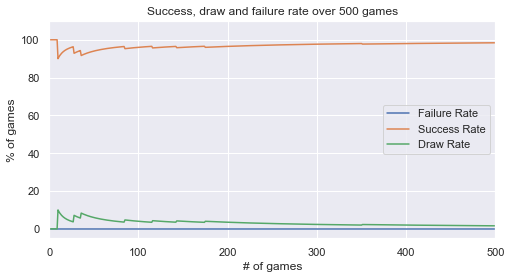

Took 22436.305 seconds


In [6]:
start = time.time()

num_sims = 500
ai_losses = 0
ai_draws = 0
ai_wins = 0
ai_loss_rate = []
ai_win_rate = []
ai_draw_rate = []

for i in range(num_sims):
    s1 = time.time()
    game1 = TicTacToe(10,3,1,True,False)
    outcome = game1.BeginGame()
    if outcome == -1:
        ai_losses += 1
    elif outcome == 1:
        ai_wins += 1
    elif outcome == 0:
        ai_draws += 1
    ai_loss_rate.append((ai_losses*100)/(i+1))
    ai_win_rate.append((ai_wins*100)/(i+1))
    ai_draw_rate.append((ai_draws*100)/(i+1))
    
print(f"10x10 in 3 seconds\nFailure rate: {(ai_losses/num_sims)*100:.2f}%")
print(f"Success rate: {(ai_wins/num_sims)*100:.2f}%\n")
print(f"Draw rate: {(ai_draws/num_sims)*100:.2f}%\n")

plt.figure(figsize = [8,4])
plt.plot(range(1, num_sims+1), ai_loss_rate, label = "Failure Rate")
plt.plot(range(1, num_sims+1), ai_win_rate, label = "Success Rate")
plt.plot(range(1, num_sims+1), ai_draw_rate, label = "Draw Rate")
plt.title(f"Success, draw and failure rate over {num_sims} games")
plt.xlabel("# of games")
plt.ylabel("% of games")
plt.axis([0,num_sims,-5,110])
plt.legend()
plt.show()

print(f"Took {time.time()-start:.3f} seconds")